## Data fields

Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
#from pyglmnet import GLM # Marco: need to understand how to install this 
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


from pandas import ExcelWriter  #Marco: this is useful to write in excel

In [42]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

#target = train.SalePrice
#train.ix[:3].columns.values

In [43]:
#Marco: useful function to write in xls file

#writer = ExcelWriter('all_data_temp.xlsx')
#all_data.to_excel(writer,'AllData_GetDummies')
#writer.save()

In [44]:

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [5]:
#Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    return("Skewness = ",skew(dataset[feature].dropna()))

In [6]:
# Scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    return()

In [7]:
#Marco: uncomment to view this plot
#scatplot(train["GrLivArea"],train["SalePrice"])
#distskew(train,"ScreenPorch")

In [8]:
#Remove outliers from the training set only
#in this way we will not alter the number of the test example !!



#print(train.sort_values(by = 'GrLivArea', ascending = False)[:2])
print(train[train['GrLivArea'] > 4000].index)
#train = train.drop(train[train['Id'] == 1299].index)
#train = train.drop(train[train['Id'] == 524].index)

train = train.drop(train[train['GrLivArea'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF']> 6000].index)

#train = train.reset_index()

#print(train['GrLivArea'])

Int64Index([523, 691, 1182, 1298], dtype='int64')


In [9]:
# remove outlier for LotFrontage and mean imputation
train = train.drop(train[train['LotFrontage']>150].index)
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())

In [10]:
# Removing outlier for LotArea and transforming
train = train.drop(train[train['LotArea']>50001].index)

In [11]:
all_data = pd.concat((train.loc[:,'Id':'SaleCondition'],
                      test.loc[:,'Id':'SaleCondition']))
print("\n train",train.shape)
print("\n test",test.shape)
print("\nall_data",all_data.shape)

#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Get Categorical data in a fast way:
categorical_features = pd.DataFrame(all_data.describe(include = ['O'])).columns

prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

('\n train', (1439, 81))
('\n test', (1459, 80))
('\nall_data', (2898, 80))


# Data Cleaning
Add here all the operation useful to remove data with comment that justify your actions (e.g. removing outliers)

In [12]:
#missing data
REMOVING_THRESH = 0.8

total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
#MDV: remove the feature that has more than 10% of missing values
print("\n We are going to remove the below features : \n",missing_data[missing_data['Percent'] > REMOVING_THRESH])

all_data = all_data.drop((missing_data[missing_data['Percent'] > REMOVING_THRESH]).index,1)

print("\n After removed data the new dim of all_data are\n",all_data.shape)


              Total   Percent
PoolQC         2891  0.997585
MiscFeature    2795  0.964458
Alley          2701  0.932022
Fence          2329  0.803658
FireplaceQu    1418  0.489303
LotFrontage     227  0.078330
GarageCond      158  0.054520
GarageQual      158  0.054520
GarageYrBlt     158  0.054520
GarageFinish    158  0.054520
('\n We are going to remove the below features : \n',              Total   Percent
PoolQC        2891  0.997585
MiscFeature   2795  0.964458
Alley         2701  0.932022
Fence         2329  0.803658)
('\n After removed data the new dim of all_data are\n', (2898, 76))


# Some Feature Engineering
Put here all the data manipulation 

In [13]:
#scatplot(np.log1p(train["TotalBsmtSF"]),train["SalePrice"])

/root/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


('Skewness = ', 0.9776209704727413)

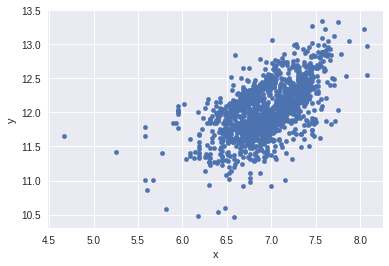

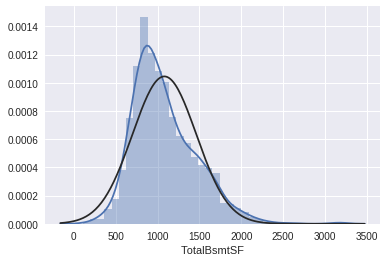

In [14]:
#Marco: replace the TotalBsmtSF = 0 with the relative GrLivArea value of that house.
#improvment from skewness of -5.1 to 2.1

no_basement_houses_index = train[train['TotalBsmtSF']== 0].index
train['TotalBsmtSF'].loc[no_basement_houses_index] = train['GrLivArea'].loc[no_basement_houses_index]
#print(train['TotalBsmtSF'].loc[no_basement_houses_index])


#all_no_basement_houses_index= all_data[all_data['TotalBsmtSF']== 0].index
#all_data['TotalBsmtSF'].loc[all_no_basement_houses_index] = all_data['GrLivArea'].loc[all_no_basement_houses_index]


scatplot(np.log1p(train["TotalBsmtSF"]),train["SalePrice"])

distskew(train,"TotalBsmtSF")

#print(no_basement_houses_index)

In [15]:
# Feature Engineering -Log transformation 
all_data['LotArea']=np.log1p(all_data['LotArea'])

In [16]:

all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]
                 
all_data = all_data.drop("BsmtFinSF1",1)
all_data = all_data.drop("BsmtFinSF2",1)

all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath",1)
all_data = all_data.drop("HalfBath",1)
all_data = all_data.drop("BsmtFullBath",1)
all_data = all_data.drop("BsmtHalfBath",1)


print("all_data dim:",all_data.shape)

('all_data dim:', (2898, 72))


In [17]:

# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

('all_data dim: ', (2898, 73))


In [18]:
#Marco 08052017 some new features:

all_data["HasFirePlace"] =all_data["Fireplaces"]>0 
all_data["HasWoodDeck "] =all_data["WoodDeckSF"]>0 


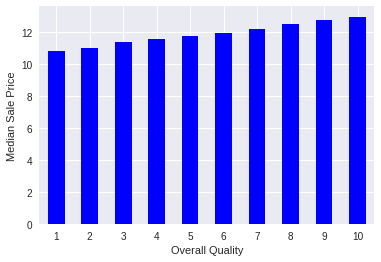

In [19]:
quality_pivot = train.pivot_table(index='OverallQual',
                                    values='SalePrice',aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In the Street column, the unique values are Pave and Grvl, which describe the type of road access to the property. In the training set, only 5 homes have gravel access. Our model needs numerical data, so we will use one-hot encoding to transform the data into a Boolean column.

In [20]:
all_data['enc_street'] = pd.get_dummies(all_data.Street, drop_first=True)

In [21]:
print ('Encoded: \n') 
print (all_data.enc_street.value_counts())

Encoded: 

1    2887
0      11
Name: enc_street, dtype: int64


# Take log of the skewed features

In [22]:
#Refresh the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Uncomment to calculate the skewness

#skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#Marco: here i've changed the train[numeric_feats] with all_data[numeric_feats]
#because we are working on all_data and train is just a part of it.

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

('all_data dim: ', (2898, 76))


# Drop some features that do not help

In [23]:
all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF",1)
all_data = all_data.drop("BedroomAbvGr",1)

all_data = all_data.drop("LowQualFinSF",1)
all_data = all_data.drop("3SsnPorch",1)
all_data = all_data.drop("PoolArea",1)

#all_data = all_data.drop("GrLivArea",1)
#all_data = all_data.drop("TotalBsmtSF",1)
all_data = all_data.drop('Condition2',1)

print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

('all_data dim: ', (2898, 69))


# Get dummies and dropna

In [24]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.median())


# Create the new X_train and X_test with all the selected features

In [25]:
# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice#already log transformed
X_train['SalePrice'] = train.SalePrice

# save 
X_train.to_csv("../data/X_train_v2.csv")
X_test.to_csv("../data/X_test_v2.csv")

X_train = X_train.drop("SalePrice",1)
print("\nShape check\n train.shape: ",train.shape)
print(" X_Train dim: ",X_train.shape)
print("\n X_test dim: ",X_test.shape)


/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('\nShape check\n train.shape: ', (1439, 84))
(' X_Train dim: ', (1439, 256))
('\n X_test dim: ', (1459, 256))


# Poste feature analysis


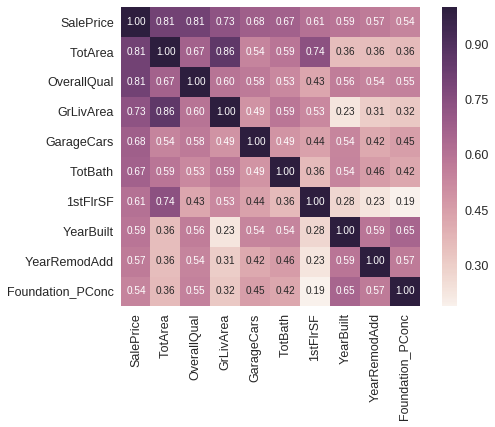

In [26]:
#Marco: [ON GOING]the analysis of the correlation between the new feature (from get_dummies) and the sale price 
X_check=X_train.assign(SalePrice=train.SalePrice, index=X_train.index)
corrmat = X_check.corr()
#Correlation matrix with Log of Sale Price
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
#cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(X_check[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

In [27]:
#Marco: 27042017:
#Removing the smallest correlated variables give no big advantages in terms of LB score

# Fit Model: Ridge (L2 Norm)

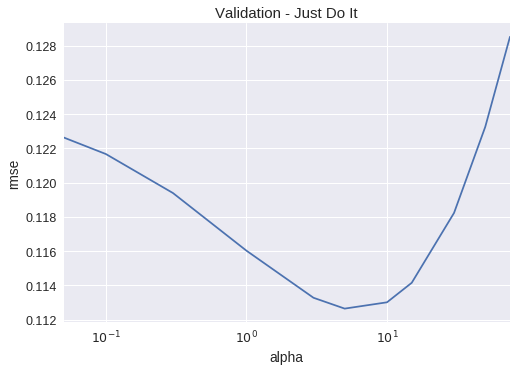

('The min value of Ridge is ', 0.11264463262406303)


In [28]:

#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
           for alpha in alphas]
    
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
#Marco: added log scale to have a better view of the minimum
plt.xscale("log")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [29]:
#Choose the best alpha by taking the alpha that give the lowest rmse
best_alpha = 8
# Now fit Ridge model
model_ridge = Ridge(alpha = best_alpha).fit(X_train, y)


# # Fit Model: Lasso (L1 Norm)

In [30]:
#distskew(X_train,"GrLivArea")
#distskew(X_train,"TotalBsmtSF")
#distskew(X_train,"TotArea")

('The min value of Lasso is ', 0.10952313042149461)
Lasso picked 96 variables and eliminated the other 160 variables


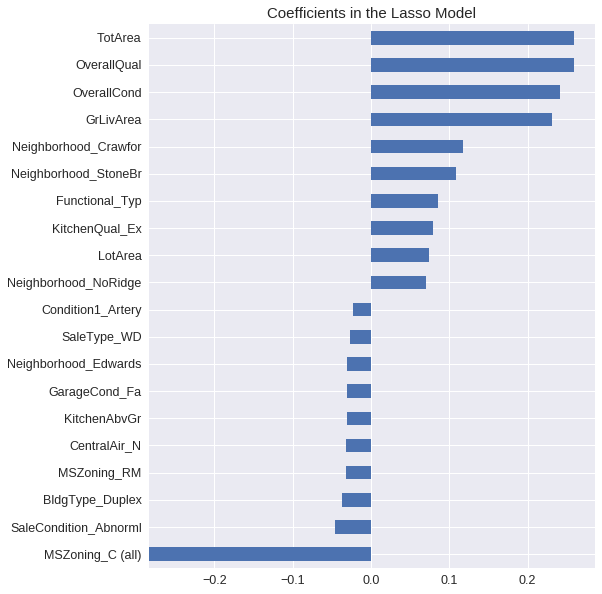

In [31]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection 

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")  
plt.show()  

#Also note that unlike the feature importance you'd get from a random forest 
#these are actual coefficients in your model - so you can say precisely 
#why the predicted price is what it is. 
#The only issue here is that we log_transformed both the target 
#and the numeric features 
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

#solution = pd.DataFrame({"id":test.Id, "SalePrice":preds_val})
#solution.to_csv("MDV_Lasso_v1.csv", index = False)


preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

# Fit model: XGBoost

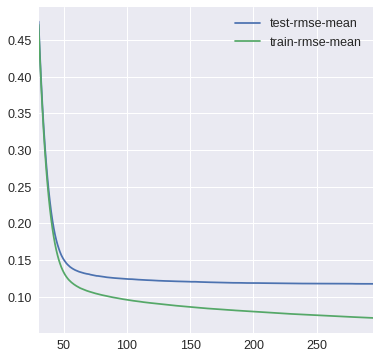

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
#Let's add an xgboost model to our linear model to see 
#if we can improve our score:

#y = preds_log["residuals"]
    
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y)

# Now fit GLM net model

In [33]:
#model_glm = GLM(distr='gaussian')
#scaler1 = StandardScaler().fit(X_train)
#scaler2 = StandardScaler().fit(X_test)
#model_glm.fit(scaler1.transform(X_train), y)

# Now combine the models for final prediction

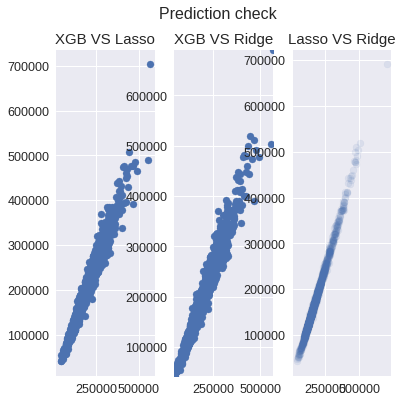

In [34]:
from matplotlib import gridspec

xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

#Marco: I still don't have the glm available on my Jupyter env
#glm_preds = np.expm1(model_glm.predict(scaler2.transform(X_test)))
predictions_lasso = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
#predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
#plt.show()

predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})

lasso_vs_ridge = pd.DataFrame({"lasso":lasso_preds, "ridge":ridge_preds})

fig = plt.figure()


fig.suptitle("Prediction check", fontsize=16)
ax = plt.subplot("131")
ax.set_title("XGB VS Lasso")
ax.scatter(xgb_preds,lasso_preds)

#axes = plt.gca()
#ax.set_xlim([xmin,xmax])
#axes.set_ylim([ymin,ymax])

ax = plt.subplot("132")
ax.set_title("XGB VS Ridge")
ax.scatter(xgb_preds,ridge_preds)
ax.autoscale(tight=True)

ax = plt.subplot("133")
ax.set_title("Lasso VS Ridge")
ax.scatter(lasso_preds,ridge_preds,alpha=.1)

plt.show()



#predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})
#predictions.plot(x = "xgb", y = "ridge", kind = "scatter")
#plt.show()



#Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves 
#the score although in this case it doesn't help that much.


In [40]:

#Marco 1704207: this last step should be performed after the evaluation of the results of Robert's models.
#for now it is up to you how to proceed for your feature engineering evaluation. I will use lasso/ridge.


#preds = 0.30*lasso_preds + 0.30*ridge_preds + 0.40*xgb_preds
preds = 0.60*lasso_preds + 0.40*xgb_preds
#preds = lasso_preds
#preds = ridge_preds
#preds= xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})

#N.B. USE YOUR RELATIVE PATH HERE FOR THE CORRECT OUTPUT:
#Obaidur:
#solution.to_csv("D:/acads/ds/kaggle/house-price/my_solution_eight.csv", index = False)
#Marco
#solution.to_csv("C:\\Users\Marco Di Vivo\\Documents\\Marco\\MachineLearning\\0_Kaggle\\1_HousePrediction\\Ridge_060517.csv", index = False)
solution.to_csv("//home//markos//Scrivania//HousePriceOutput//test.csv", index = False)
#Ayush:
#solution.to_csv("C:/Users/Aoos/Documents/Projects/HousePrice/Solution/solution1.csv", index = False)

()

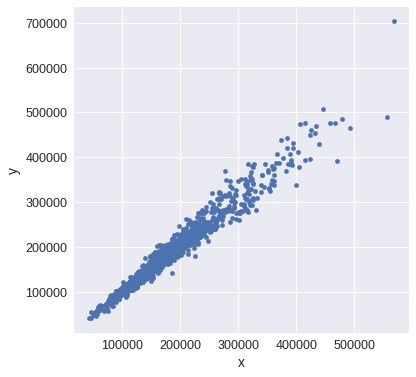

In [36]:
scatplot(xgb_preds,lasso_preds)

Score Report


In [37]:
#Marco :
#0.60*lasso_preds + 0.40*xgb_preds  we get 0.11997 score on the LB   17/04/2017
#only lasso                         we get 0.12049 score on the LB   17/04/2017
#only ridge                         we get 0.12365 score on the LB   17/04/2017
#20/04/2017 after last update from Ayush:
#0.60*lasso_preds + 0.40*xgb_preds  we get 0.11914